[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/042_cnns/cnns.ipynb)

# Redes Neuronales Convolucionales

En posts anteriores hemos presentado varias arquitecturas diferentes de `redes neuronales`. Algunos ejemplos son el [`Perceptrón Multicapa`](https://sensioai.com/blog/023_mlp_backprop) o las [`redes neuronales recurrentes`](https://sensioai.com/blog/034_rnn_intro), las cuales hemos aplicado para [predicción de series temporales](https://sensioai.com/blog/035_rnn_forecast) y varias aplicaciones de [lenguaje](https://sensioai.com/blog/038_clasificacion_texto). En este post vamos a presentar una nueva arquitectura de `red neuronal` conocida como `red neuronal convolucional`, especialmente diseñada para trabajar con imágenes.

## Introducción

Las `redes neuronales convolucionales` (CNNs) surgieron del estudio del córtex visual del cerebro y se han utilizado en el reconocimiento de imágenes desde la década de los 80. En los últimos años, gracias al aumento de la potencia computacional, la cantidad de datos de entrenamiento disponibles y los trucos ya explicados anteriormente para entrenar redes profundas, las CNNs han logrado lograr un rendimiento sobrehumano en algunas tareas visuales complejas. Este tipo de red se puede encontrar en servicios de búsqueda de imágenes, coches autónomos, sistemas de clasificación de vídeo automático y muchas otras aplicaciones. Además, las CNNs no se limitan a la percepción visual, también tienen éxito en tareas como el reconocimiento de voz y el procesamiento de datos tridimensionales.

### El córtex visual

Las neuronas del córtex visual tienen un pequeño *campo receptivo local*, lo que significa que reaccionan solo a los estímulos visuales ubicados en una región limitada del campo visual. Los campos receptivos de diferentes neuronas pueden superponerse y juntos forman el campo visual completo.

![](https://mymlpics.s3.eu-de.cloud-object-storage.appdomain.cloud/visual_cortex.png)

Las neuronas de las primeras capas del córtex visual reaccionan solo ante ciertos patrones simples, como por ejemplo líneas horizontales mientras que otras reaccionan a líneas verticales (dos neuronas pueden tener el mismo campo receptivo pero reaccionan a diferentes orientaciones de línea). En las capas siguientes, las neuronas tienen campos receptivos más grandes y reaccionan a patrones más complejos, que pueden ser combinaciones de patrones de nivel inferior, construyendo de esta manera una jerarquía en diferentes capas que resultan finalmente en las formas y colores que vemos.

Basándose en estos conceptos, Yann LeCunn introdujo las CNNs en 1998 en la famosa arquitectura [LeNet-5](https://colab.research.google.com/drive/1fqxaTs-Ux9KQHyCJsToFTZwSNoHv9rKe#scrollTo=CMK6qB1EdfqC), utilizada por los bancos para reconocer de manera automática los números manuscritos en cheques para un procesamiento más rápido.

## La Capa Convolucional

Como veremos más adelante, las `redes convolucionales` están formadas por varias capas con diferente responsabilidad. De entre estas capas, la más importante es la `capa convolucional` la cual es responsable de identificar y construir las diferentes formas, colores y texturas de manera similar al córtex visual. Para llevar a cabo esta tarea usaremos un conjunto de *filtros* (también llamados *kernels*) los cuales deslizaremos por toda la imagen aplicando la operación *convolución*. Esta operación consiste en aplicar el producto escalar entre el filtro y los píxeles de la imagen cubiertos por el filtro, lo que se conoce como el *campo receptivo* (o *receptive field*). En el siguiente gif puedes ver esta operación en acción, en la que tenemos un filtro de 3x3 el cual deslizamos por nuestra imagen, la cual tiene una resolución de 5x5. Para cada posible posición del filtro dentro de la imagen, calculamos el producto de cada pixel por el valor del filtro correspondiente y guardamos el resultado en el mapa de salida.

![](https://miro.medium.com/max/1052/1*GcI7G-JLAQiEoCON7xFbhg.gif)

En este segundo ejemplo estamos aplicando la misma operación, pero ahora en el caso de que nuestra imagen tenga 3 canales (una imagen en color RGB). En este caso, nuestros filtros también tienen 3 canales. Además estamos aplicando más de un filtro, lo cual resulta en número de canales en el mapa de salida igual al número de filtros utilizados.

![](https://cdn-media-1.freecodecamp.org/images/gb08-2i83P5wPzs3SL-vosNb6Iur5kb5ZH43)

Vamos a ver un ejemplo de aplicación con imágenes reales, en este caso con imágenes del dataset CIFAR10 con el cual ya hemos trabajado anteriormente.

In [1]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
device

'cuda'

In [3]:
import torch.optim as optim
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.Resize((64, 64))])

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 102013366.94it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
print(trainset[110][0])

<PIL.Image.Image image mode=RGB size=64x64 at 0x7D9F370DFA30>


In [6]:
import numpy as np

train_imgs, train_labels = np.array([np.array(i[0]) for i in trainset]), np.array([i[1] for i in trainset])
test_imgs, test_labels = np.array([np.array(i[0]) for i in testset]), np.array([i[1] for i in testset])

train_imgs.shape, test_imgs.shape

((50000, 64, 64, 3), (10000, 64, 64, 3))

Una vez convertidas todas las imágenes a arrays de `Numpy`, vamos a visualizar un ejemplo aleatorio.

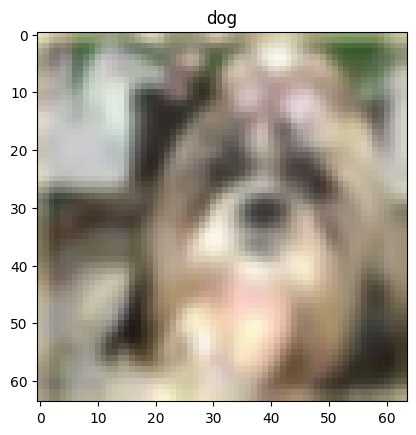

In [7]:
import random
import matplotlib.pyplot as plt

ix = random.randint(0, len(train_imgs))
img, label = train_imgs[ix], train_labels[ix]
#print(img)

plt.imshow(img)
plt.title(classes[label])
plt.show()

Ahora, vamos a aplicar un filtro definido manualmente a esta imagen. En este caso aplicaremos un filtro de 3x3 con valores de 1 en la primera fila, 0 en la central y -1 en la última. Como puedes ver en el resultado, este filtro es útil para identificar líneas horizontales.

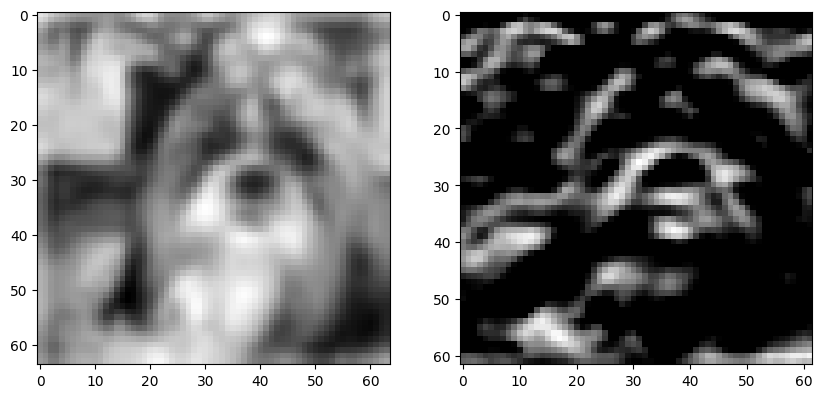

In [8]:
import numpy as np
import scipy.signal
from skimage import color
from skimage import exposure

img = color.rgb2gray(img)

kernel = np.array([[1,1,1],
                   [0,0,0],
                   [-1,-1,-1]])

edges = scipy.signal.convolve2d(img, kernel, 'valid')
edges = exposure.equalize_adapthist(edges/np.max(np.abs(edges)), clip_limit=0.03)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(img, cmap=plt.cm.gray)
ax2.imshow(edges, cmap=plt.cm.gray)
plt.show()

Si aplicamos ahora el mismo filtro, pero transpuesto, obtenemos un detector de líneas verticales.

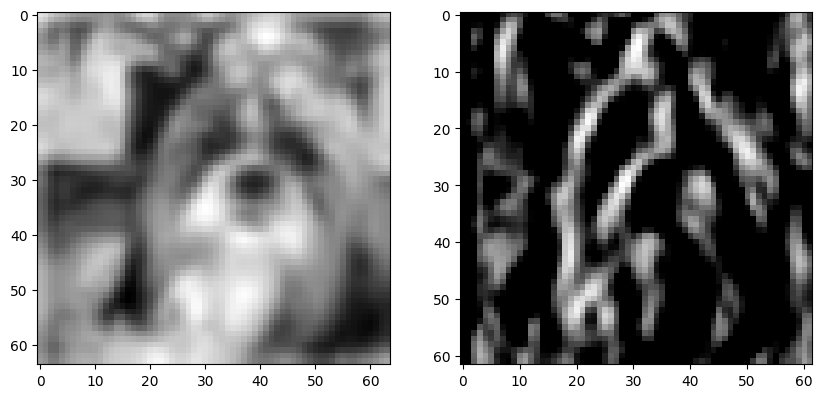

In [9]:
kernel = np.array([[1, 0, -1],
                   [1, 0, -1],
                   [1, 0, -1]])

edges = scipy.signal.convolve2d(img, kernel, 'valid')
edges = exposure.equalize_adapthist(edges/np.max(np.abs(edges)), clip_limit=0.03)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(img, cmap=plt.cm.gray)
ax2.imshow(edges, cmap=plt.cm.gray)
plt.show()

De la misma manera, el siguiente filtro será útil para detectar bordes en cualquier orientación.

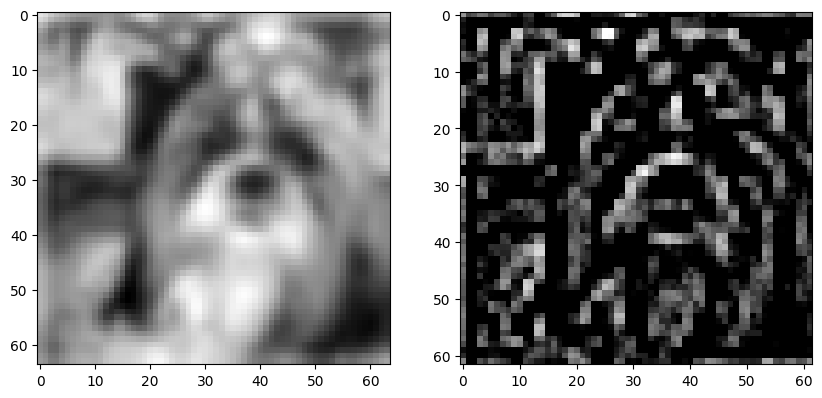

In [10]:
kernel = np.array([[0,-1,0],
                   [-1,4,-1],
                   [0,-1,0]])

edges = scipy.signal.convolve2d(img, kernel, 'valid')
edges = exposure.equalize_adapthist(edges/np.max(np.abs(edges)), clip_limit=0.03)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(img, cmap=plt.cm.gray)
ax2.imshow(edges, cmap=plt.cm.gray)
plt.show()

Como puedes ver, al aplicar varios filtros a nuestra imagen podemos obtener información relevante a la hora de llevar a cabo tareas tales como la clasificación de la imagen, detectar varios objetos en ella o generar una descripción textual de la misma. La pregunta ahora es: ¿Y cómo decidimos que filtros utilizar? La respuesta es fácil, dejaremos que sea la propia red neuronal quién aprenda estos valores a través del proceso de entrenamiento de manera que sea ella misma quien decida qué patrones son los más importantes a la hora de llevar a cabo su tarea. Así pues, los filtros serán ahora los parámetros de nuestra red.

### Implementación en Pytorch

En `Pytorch` tenemos implementada la capa convolucional en el clase `torch.nn.Conv2D`. A esta capa le pasamos como parámetros el número de canales de la imagen a la entrada, el número de filtros, el tamaño del filtro y otros parámetros relevantes de los que hablaremos más adelante. Si miras en la [documentación](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), esta capa espera un tensor a la entrada con dimensiones $(N,C_{in},H,W)$, dónde $N$ es el tamaño del *batch*, $C_{in}$ es el número de canales del mapa de entrada, $H$ es el alto y $W$ el ancho del mapa.

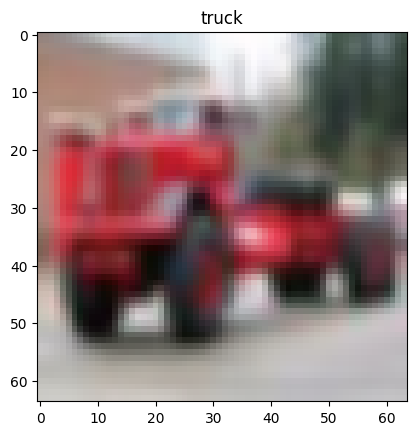

In [11]:
ix = random.randint(0, len(train_imgs))
img, label = train_imgs[ix], train_labels[ix]

plt.imshow(img)
plt.title(classes[label])
plt.show()

In [12]:
# convertir la imágen en tensor con dimensiones (N, C_in, H, W)

img_tensor = torch.from_numpy(img / 255.).unsqueeze(0)
img_tensor = img_tensor.permute(0, 3, 1, 2).float()

img_tensor.shape, img_tensor.dtype

(torch.Size([1, 3, 64, 64]), torch.float32)

In [13]:
# aplicamos 10 filtros de tamaño 3x3

conv = torch.nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = 3)

output = conv(img_tensor)

# dimensiones: (N, #filtros, H', W')
output.shape

torch.Size([1, 10, 62, 62])

Como puedes ver las dimensiones del tensor de salida son diferentes al tensor de entrada. En primer lugar, el número de canales del mapa de entrada ahora es el número de filtros aplicados (el resultado de aplicar cada filtro se guarda en un canal). En cuanto al ancho y alto, dependerá de la relación entre el tamaño de la imagen y el del filtro. Puedes calcular estas dimensiones de la siguiente manera

$$ o = \lfloor \frac{n+2p-m}{s} \rfloor + 1 $$

donde $o$ es la dimensión de salida, $n$ la de entrada, $m$ es el tamaño del filtro y $p$ y $s$ son dos parámetros con los que podemos jugar para ajustar el tamaño de salida. $p$ es el *padding* y consiste en el número de valores extra que añadimos en los bordes para aumentar el tamaño de la entrada. $s$ es el *stride*, y controla el número de pixeles que el filtro salta en cada paso. $\lfloor \cdot \rfloor$ es el operador *floor*, que redondea cualquier resultado a la baja.

Usar $p = 1$ y $s = 1$ con un filtro de 3x3 no cambiará el tamaño de la imagen.

In [14]:
conv = torch.nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = 5, padding = 0, stride = 2)

output = conv(img_tensor)

# dimensiones: (N, #filtros, H', W')
output.shape

torch.Size([1, 10, 30, 30])

In [15]:
img_tensor.shape

torch.Size([1, 3, 64, 64])

Aplicar un salto de 2 pixeles en la aplicación del filtro, $s = 2$, reducirá el tamaño a la mitad.

In [16]:

conv = torch.nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = 5, padding = 1, stride = 2)

output = conv(img_tensor)

# dimensiones: (N, #filtros, H', W')
output.shape

torch.Size([1, 10, 31, 31])

In [17]:
conv1 = torch.nn.Conv2d(in_channels = 10, out_channels = 64, kernel_size = 3, padding = 0, stride = 1)

output2 = conv1(output)

# dimensiones: (N, #filtros, H', W')
output2.shape

torch.Size([1, 64, 29, 29])

En una `red convolucional` tendremos varias de estas `capas convolucionales` en diferentes capas consecutivas, de manera que las entradas a unas capas serán las salidas de las anteriores. De esta manera, la red será capaz de construir patrones cada vez más elaborados a partir de patrones más sencillos. Puedes ver una animación del funcionamiento de esta capa en el siguiente [vídeo](https://www.youtube.com/watch?v=f0t-OCG79-U). También, en el siguiente gif, puedes ver un ejemplo de aplicación.

![](https://thumbs.gfycat.com/AffectionateMemorableGreyhounddog-size_restricted.gif)


## Capas de *Pooling*

Si bien hemos visto que jugando con los tamaños del filtro, *stride* y *padding* podemos controlar el tamaño de los mapas generados por las capas convolucionales, es también común el uso de capas *pooling* para reducir los mapas de características.

![](https://miro.medium.com/max/1456/1*WvHC5bKyrHa7Wm3ca-pXtg.gif)

Estas capas también aplican un filtro sobre su entrada, pero en este caso es un solo filtro que además no tiene parámetros sino que aplica una función predeterminada en su campo receptivo (mínimo, máximo, promedio, etc). La idea detrás del uso de este tipo de capas es la de reducir la resolución de los mapas de características, reduciendo así el coste computacional para entrenar la `red neuronal`, pero manteniendo las características importantes para el reconocimiento de patrones.

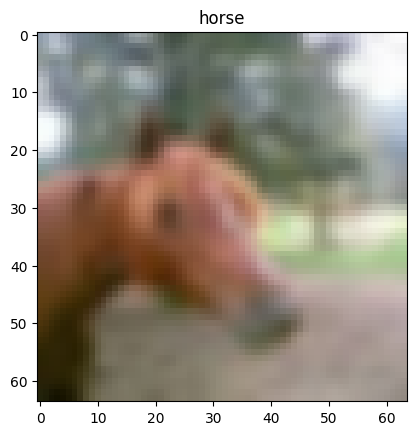

In [18]:
ix = random.randint(0, len(train_imgs))
img, label = train_imgs[ix], train_labels[ix]

plt.imshow(img)
plt.title(classes[label])
plt.show()

In [19]:
pool = torch.nn.MaxPool2d(2, padding=0, stride=2)

img_tensor = torch.from_numpy(img / 255.).unsqueeze(0).permute(0, 3, 1, 2).float()
output = pool(img_tensor)
output.shape

torch.Size([1, 3, 32, 32])

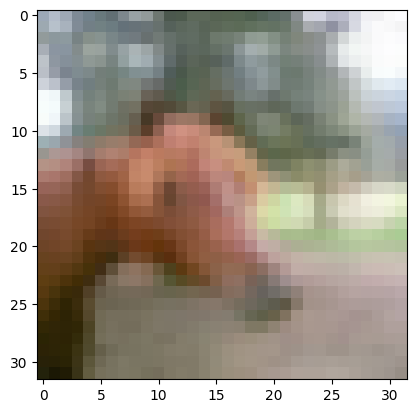

In [20]:
plt.imshow(output.squeeze(0).permute(1,2,0))
plt.show()

## Redes Convolucionales

Una vez hemos visto los comoponentes principales de las `redes convolucionales` vamos a ver un ejemplo de cómo podemos implementar una red convolucional completa para, en este caso, la clasificación de las imágenes en el dataset MNIST. En primer lugar descargamos el dataset.

In [21]:
dataloader = {
    'train': torch.utils.data.DataLoader(torchvision.datasets.CIFAR10('../data', train=True, download=True,
                       transform=torchvision.transforms.Compose([
                            transforms.Resize((64, 64)),
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize((0.1307,), (0.3081,))
                            ])
                      ), batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(torchvision.datasets.CIFAR10('../data', train=False,
                   transform=torchvision.transforms.Compose([
                        transforms.Resize((64, 64)),
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1307,), (0.3081,))
                        ])
                     ), batch_size=128, shuffle=False, pin_memory=True)
}

100%|██████████| 170498071/170498071 [00:02<00:00, 83227124.11it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data


Vamos a definir una `red convolucional` con varias `capas convolucionales` y `capas de pooling`. Para poder clasificar las imágenes, conectaremos las salidas de la última capa de la red convolucional con un `MLP` para obtener las predicciones finales.

In [22]:
def block(c_in, c_out, k=5, p=0, s=2, pk=2, ps=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

def block2(c_in, c_out):
    return torch.nn.Sequential(
        torch.nn.Linear(c_in, c_out),
        torch.nn.ReLU()
    )

class CNN1(torch.nn.Module):
  def __init__(self, n_channels=3, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 32)
    self.conv2 = block(32, 64)
    self.conv3 = block(64, 128)
    #self.conv4 = block(64, 128)
    self.fc = torch.nn.Linear(128 * 3 * 3, n_outputs)

  def forward(self, x):
    #print("Dimensiones:")
    #print("Entrada: ", x.shape)
    x = self.conv1(x)
    #print("conv1: ", x.shape)
    x = self.conv2(x)
    #print("conv2: ", x.shape)
    x = self.conv3(x)
    #print("conv3: ", x.shape)
    #x = self.conv4(x)
    #print("conv4: ", x.shape)
    x = x.view(x.shape[0], -1)
    #print("pre fc: ", x.shape)
    x = self.fc(x)
    #print("Salida: ", x.shape)
    return x

In [23]:
model = CNN1()
output = model(torch.randn(64, 3, 64, 64))
print(output.shape)

torch.Size([64, 10])


AL utilizar en las capas convolucionales k=5 , p=0, s=2 y en los pooling k=2, s=1. Con las dimensiones de las imagenes de 64x64 solo podemos llegar hasta 3 capas convoluciones con sus respectivos pooling , por que apartir de la cap3 ya no se puede disminuir la dimensin espacial , si quisieramos hacer para 4 capas convolucionales con esas especificaciones el tamaño de la imagen dentria que aumnetar

In [24]:
class CNN(torch.nn.Module):
  def __init__(self, n_channels=3, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 256)
    self.conv2 = block(256, 128)
    self.conv3 = block(128,64)
    self.fc = torch.nn.Linear(64*3*3, n_outputs)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

Ahora, podemos entrenar la red utilizando nuestro bucle de entrenamiento.

In [25]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=30):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [26]:
model = CNN()
fit(model, dataloader)

val_loss 1.31300 val_acc 0.52799: 100%|██████████| 79/79 [00:06<00:00, 12.62it/s]


Epoch 1/30 loss 1.56619 val_loss 1.31300 acc 0.42947 val_acc 0.52799


val_loss 1.17924 val_acc 0.57743: 100%|██████████| 79/79 [00:06<00:00, 11.46it/s]


Epoch 2/30 loss 1.23668 val_loss 1.17924 acc 0.55998 val_acc 0.57743


val_loss 1.12614 val_acc 0.60394: 100%|██████████| 79/79 [00:06<00:00, 11.76it/s]


Epoch 3/30 loss 1.12817 val_loss 1.12614 acc 0.60280 val_acc 0.60394


val_loss 1.06121 val_acc 0.62609: 100%|██████████| 79/79 [00:06<00:00, 12.83it/s]


Epoch 4/30 loss 1.05483 val_loss 1.06121 acc 0.63169 val_acc 0.62609


val_loss 1.13509 val_acc 0.61096: 100%|██████████| 79/79 [00:06<00:00, 11.59it/s]


Epoch 5/30 loss 1.01480 val_loss 1.13509 acc 0.64708 val_acc 0.61096


val_loss 1.13169 val_acc 0.59840: 100%|██████████| 79/79 [00:07<00:00, 11.24it/s]


Epoch 6/30 loss 0.97114 val_loss 1.13169 acc 0.65941 val_acc 0.59840


val_loss 0.98902 val_acc 0.65655: 100%|██████████| 79/79 [00:06<00:00, 12.76it/s]


Epoch 7/30 loss 0.94283 val_loss 0.98902 acc 0.66904 val_acc 0.65655


val_loss 1.01666 val_acc 0.64824: 100%|██████████| 79/79 [00:06<00:00, 12.25it/s]


Epoch 8/30 loss 0.91076 val_loss 1.01666 acc 0.68248 val_acc 0.64824


val_loss 1.05008 val_acc 0.62955: 100%|██████████| 79/79 [00:06<00:00, 11.78it/s]


Epoch 9/30 loss 0.88391 val_loss 1.05008 acc 0.69092 val_acc 0.62955


val_loss 1.03825 val_acc 0.64537: 100%|██████████| 79/79 [00:06<00:00, 11.67it/s]


Epoch 10/30 loss 0.86357 val_loss 1.03825 acc 0.69709 val_acc 0.64537


val_loss 1.06548 val_acc 0.64448: 100%|██████████| 79/79 [00:06<00:00, 12.15it/s]


Epoch 11/30 loss 0.84465 val_loss 1.06548 acc 0.70291 val_acc 0.64448


val_loss 0.99429 val_acc 0.65704: 100%|██████████| 79/79 [00:06<00:00, 13.00it/s]


Epoch 12/30 loss 0.82380 val_loss 0.99429 acc 0.71244 val_acc 0.65704


val_loss 1.01433 val_acc 0.65328: 100%|██████████| 79/79 [00:06<00:00, 12.15it/s]


Epoch 13/30 loss 0.80245 val_loss 1.01433 acc 0.71765 val_acc 0.65328


val_loss 1.09736 val_acc 0.63627: 100%|██████████| 79/79 [00:06<00:00, 11.49it/s]


Epoch 14/30 loss 0.79376 val_loss 1.09736 acc 0.72253 val_acc 0.63627


val_loss 1.01674 val_acc 0.66614: 100%|██████████| 79/79 [00:06<00:00, 12.20it/s]


Epoch 15/30 loss 0.77073 val_loss 1.01674 acc 0.73054 val_acc 0.66614


val_loss 1.05831 val_acc 0.64913: 100%|██████████| 79/79 [00:06<00:00, 12.57it/s]


Epoch 16/30 loss 0.75568 val_loss 1.05831 acc 0.73463 val_acc 0.64913


val_loss 1.01260 val_acc 0.67118: 100%|██████████| 79/79 [00:06<00:00, 11.69it/s]


Epoch 17/30 loss 0.74266 val_loss 1.01260 acc 0.74113 val_acc 0.67118


val_loss 1.06193 val_acc 0.65299: 100%|██████████| 79/79 [00:06<00:00, 11.49it/s]


Epoch 18/30 loss 0.72008 val_loss 1.06193 acc 0.74816 val_acc 0.65299


val_loss 1.07629 val_acc 0.65843: 100%|██████████| 79/79 [00:06<00:00, 11.67it/s]


Epoch 19/30 loss 0.70552 val_loss 1.07629 acc 0.75364 val_acc 0.65843


val_loss 1.09040 val_acc 0.65407: 100%|██████████| 79/79 [00:06<00:00, 12.94it/s]


Epoch 20/30 loss 0.69418 val_loss 1.09040 acc 0.75791 val_acc 0.65407


val_loss 1.06579 val_acc 0.65981: 100%|██████████| 79/79 [00:06<00:00, 12.62it/s]


Epoch 21/30 loss 0.67345 val_loss 1.06579 acc 0.76447 val_acc 0.65981


val_loss 1.07342 val_acc 0.66199: 100%|██████████| 79/79 [00:06<00:00, 11.80it/s]


Epoch 22/30 loss 0.65989 val_loss 1.07342 acc 0.76984 val_acc 0.66199


val_loss 1.06697 val_acc 0.66673: 100%|██████████| 79/79 [00:06<00:00, 11.42it/s]


Epoch 23/30 loss 0.65176 val_loss 1.06697 acc 0.77138 val_acc 0.66673


val_loss 1.09449 val_acc 0.66258: 100%|██████████| 79/79 [00:06<00:00, 12.95it/s]


Epoch 24/30 loss 0.63852 val_loss 1.09449 acc 0.77623 val_acc 0.66258


val_loss 1.15024 val_acc 0.64854: 100%|██████████| 79/79 [00:06<00:00, 12.94it/s]


Epoch 25/30 loss 0.62141 val_loss 1.15024 acc 0.78257 val_acc 0.64854


val_loss 1.11385 val_acc 0.66752: 100%|██████████| 79/79 [00:06<00:00, 11.91it/s]


Epoch 26/30 loss 0.61204 val_loss 1.11385 acc 0.78531 val_acc 0.66752


val_loss 1.14366 val_acc 0.66307: 100%|██████████| 79/79 [00:06<00:00, 11.58it/s]


Epoch 27/30 loss 0.59215 val_loss 1.14366 acc 0.79276 val_acc 0.66307


val_loss 1.18612 val_acc 0.65259: 100%|██████████| 79/79 [00:06<00:00, 11.77it/s]


Epoch 28/30 loss 0.58683 val_loss 1.18612 acc 0.79216 val_acc 0.65259


val_loss 1.15130 val_acc 0.66574: 100%|██████████| 79/79 [00:06<00:00, 12.94it/s]


Epoch 29/30 loss 0.56750 val_loss 1.15130 acc 0.80205 val_acc 0.66574


val_loss 1.16777 val_acc 0.66614: 100%|██████████| 79/79 [00:06<00:00, 12.36it/s]

Epoch 30/30 loss 0.55696 val_loss 1.16777 acc 0.80389 val_acc 0.66614


con 10 epock se logro llegar a un 72 % de precision y con 20 epoch se logro 76 % de presicion

In [27]:
model1 = CNN1()
fit(model1, dataloader)

val_loss 1.34773 val_acc 0.51820: 100%|██████████| 79/79 [00:05<00:00, 13.67it/s]


Epoch 1/30 loss 1.50594 val_loss 1.34773 acc 0.45538 val_acc 0.51820


val_loss 1.09428 val_acc 0.62144: 100%|██████████| 79/79 [00:05<00:00, 13.61it/s]


Epoch 2/30 loss 1.15116 val_loss 1.09428 acc 0.59627 val_acc 0.62144


val_loss 1.02065 val_acc 0.64962: 100%|██████████| 79/79 [00:05<00:00, 15.56it/s]


Epoch 3/30 loss 1.01059 val_loss 1.02065 acc 0.64930 val_acc 0.64962


val_loss 0.97779 val_acc 0.66901: 100%|██████████| 79/79 [00:04<00:00, 15.98it/s]


Epoch 4/30 loss 0.92779 val_loss 0.97779 acc 0.67755 val_acc 0.66901


val_loss 0.94492 val_acc 0.67652: 100%|██████████| 79/79 [00:04<00:00, 15.82it/s]


Epoch 5/30 loss 0.85339 val_loss 0.94492 acc 0.70426 val_acc 0.67652


val_loss 0.97102 val_acc 0.67039: 100%|██████████| 79/79 [00:05<00:00, 15.22it/s]


Epoch 6/30 loss 0.79699 val_loss 0.97102 acc 0.72367 val_acc 0.67039


val_loss 0.95967 val_acc 0.67623: 100%|██████████| 79/79 [00:05<00:00, 15.10it/s]


Epoch 7/30 loss 0.75692 val_loss 0.95967 acc 0.73905 val_acc 0.67623


val_loss 0.96978 val_acc 0.68295: 100%|██████████| 79/79 [00:05<00:00, 13.96it/s]


Epoch 8/30 loss 0.71153 val_loss 0.96978 acc 0.75282 val_acc 0.68295


val_loss 0.93797 val_acc 0.69333: 100%|██████████| 79/79 [00:05<00:00, 14.14it/s]


Epoch 9/30 loss 0.69053 val_loss 0.93797 acc 0.75937 val_acc 0.69333


val_loss 1.00180 val_acc 0.67425: 100%|██████████| 79/79 [00:05<00:00, 14.28it/s]


Epoch 10/30 loss 0.65612 val_loss 1.00180 acc 0.77214 val_acc 0.67425


val_loss 0.97544 val_acc 0.68681: 100%|██████████| 79/79 [00:05<00:00, 15.79it/s]


Epoch 11/30 loss 0.62532 val_loss 0.97544 acc 0.78143 val_acc 0.68681


val_loss 0.98791 val_acc 0.69314: 100%|██████████| 79/79 [00:04<00:00, 16.13it/s]


Epoch 12/30 loss 0.59430 val_loss 0.98791 acc 0.79158 val_acc 0.69314


val_loss 1.05210 val_acc 0.68582: 100%|██████████| 79/79 [00:04<00:00, 16.07it/s]


Epoch 13/30 loss 0.56825 val_loss 1.05210 acc 0.80077 val_acc 0.68582


val_loss 1.01249 val_acc 0.69274: 100%|██████████| 79/79 [00:04<00:00, 16.04it/s]


Epoch 14/30 loss 0.54808 val_loss 1.01249 acc 0.80695 val_acc 0.69274


val_loss 1.05788 val_acc 0.68928: 100%|██████████| 79/79 [00:04<00:00, 16.22it/s]


Epoch 15/30 loss 0.51966 val_loss 1.05788 acc 0.81869 val_acc 0.68928


val_loss 1.15054 val_acc 0.67069: 100%|██████████| 79/79 [00:04<00:00, 16.24it/s]


Epoch 16/30 loss 0.49401 val_loss 1.15054 acc 0.82551 val_acc 0.67069


val_loss 1.17666 val_acc 0.66673: 100%|██████████| 79/79 [00:05<00:00, 14.10it/s]


Epoch 17/30 loss 0.48259 val_loss 1.17666 acc 0.83006 val_acc 0.66673


val_loss 1.15555 val_acc 0.68157: 100%|██████████| 79/79 [00:05<00:00, 13.93it/s]


Epoch 18/30 loss 0.45616 val_loss 1.15555 acc 0.83941 val_acc 0.68157


val_loss 1.19388 val_acc 0.67544: 100%|██████████| 79/79 [00:05<00:00, 14.12it/s]


Epoch 19/30 loss 0.42963 val_loss 1.19388 acc 0.84741 val_acc 0.67544


val_loss 1.22918 val_acc 0.68523: 100%|██████████| 79/79 [00:05<00:00, 14.86it/s]


Epoch 20/30 loss 0.41603 val_loss 1.22918 acc 0.85320 val_acc 0.68523


val_loss 1.27795 val_acc 0.68028: 100%|██████████| 79/79 [00:04<00:00, 16.33it/s]


Epoch 21/30 loss 0.40810 val_loss 1.27795 acc 0.85446 val_acc 0.68028


val_loss 1.31400 val_acc 0.67820: 100%|██████████| 79/79 [00:04<00:00, 16.13it/s]


Epoch 22/30 loss 0.38451 val_loss 1.31400 acc 0.86377 val_acc 0.67820


val_loss 1.33970 val_acc 0.68196: 100%|██████████| 79/79 [00:04<00:00, 16.08it/s]


Epoch 23/30 loss 0.37147 val_loss 1.33970 acc 0.86847 val_acc 0.68196


val_loss 1.35570 val_acc 0.67850: 100%|██████████| 79/79 [00:04<00:00, 16.32it/s]


Epoch 24/30 loss 0.34845 val_loss 1.35570 acc 0.87586 val_acc 0.67850


val_loss 1.43972 val_acc 0.66940: 100%|██████████| 79/79 [00:05<00:00, 15.19it/s]


Epoch 25/30 loss 0.34083 val_loss 1.43972 acc 0.87928 val_acc 0.66940


val_loss 1.50443 val_acc 0.66871: 100%|██████████| 79/79 [00:05<00:00, 13.97it/s]


Epoch 26/30 loss 0.33342 val_loss 1.50443 acc 0.88207 val_acc 0.66871


val_loss 1.48733 val_acc 0.67405: 100%|██████████| 79/79 [00:05<00:00, 14.00it/s]


Epoch 27/30 loss 0.32645 val_loss 1.48733 acc 0.88457 val_acc 0.67405


val_loss 1.58896 val_acc 0.67197: 100%|██████████| 79/79 [00:05<00:00, 14.66it/s]


Epoch 28/30 loss 0.29773 val_loss 1.58896 acc 0.89452 val_acc 0.67197


val_loss 1.67418 val_acc 0.65981: 100%|██████████| 79/79 [00:04<00:00, 16.33it/s]


Epoch 29/30 loss 0.29944 val_loss 1.67418 acc 0.89460 val_acc 0.65981


val_loss 1.64023 val_acc 0.66802: 100%|██████████| 79/79 [00:04<00:00, 16.17it/s]

Epoch 30/30 loss 0.29358 val_loss 1.64023 acc 0.89510 val_acc 0.66802


con 10 epoch se llego a 79 % de presicion y con 20 epoch se logro un 84% de precision  

## Resumen

En este post hemos introducido la arquitectura de `red neuronal` conocida como `red neuronal convolucional`. Este tipo de redes, inspiradas en el funcionamiento del córtex visual, están especialmente diseñadas para trabajar con imágenes. Gracias a la aplicación de la `capa convolucional`, la red será capaz de reconocer diferentes formas, colores y texturas que, de manera jerárquica, irá componiendo en estructuras cada vez más complejas para poder llevar a cabo su tarea de la mejor forma posible. En futuros posts hablaremos sobre diferente arquitecturas de CNN que han aparecido durante los últimos años y que podemos utilizar para nuestras aplicaciones.